In [1]:
import random
import os
import re
import sys
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack, issparse, coo_matrix
from string import punctuation
from collections import defaultdict, Counter
from copy import deepcopy
import matplotlib.pyplot as plt

Загружаем данные. У нас есть три выборки: обучающая (train), валидационная (dev) и тестовая (test). На валидационной выборке тестируем классификатор и подбираем гиперпараметры. Результаты работы классификатора на тестовой выборке проверяются на сервере СompAI, метки для нее не предоставляются.

In [2]:
data_dir = '../FILIMDB'
glove_dir = '../GLOVE'

In [3]:
def load_data(file_name):
    """
    Reads specified file, returns list of strings
    :param file_name: file name in data_dir folder
    :returns list of strings
    """
    print('Loading %s' % file_name)
    data_path = os.path.join(data_dir, file_name)
    with open(data_path, 'r', encoding='utf8') as input_data:
        lines = input_data.readlines()
        lines = [l.strip() for l in lines]
    
    print('Loaded %d lines' % len(lines))
    return lines

In [4]:
train_texts, train_labels = load_data('train.texts'), load_data('train.labels')
dev_texts, dev_labels = load_data('dev.texts'), load_data('dev.labels')
test_texts = load_data('test.texts')

Loading train.texts
Loaded 25000 lines
Loading train.labels
Loaded 25000 lines
Loading dev.texts
Loaded 25000 lines
Loading dev.labels
Loaded 25000 lines
Loading test.texts
Loaded 10599 lines


In [5]:
char_set = set(ch for review in train_texts for ch in review)
sorted_chars = sorted(list(char_set))
print(''.join(sorted_chars))

	 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¦§¨«­®°³´·º»½¾¿ÀÁÃÄÅÈÉÊÕØÜßàáâãäåæçèéêëìíîïðñòóôöøùúûüýō–‘’“”…₤


# A

In [6]:
def tokenize(text):
    """
    Preprocesses text and split it into the list of words
    :param: text(str): movie review
    """
    # YOUR CODE HERE
    return re.findall('[\w]+', text.lower())

In [7]:
tokenized_train_texts = [tokenize(r) for r in train_texts]
tokenized_dev_texts = [tokenize(r) for r in dev_texts]
tokenized_test_texts = [tokenize(r) for r in test_texts]

In [8]:
y_train = np.array([(lambda l: 1 if l=='pos' else 0)(l) for l in train_labels])
y_dev = np.array([(lambda l: 1 if l=='pos' else 0)(l) for l in dev_labels])

In [9]:
def get_vocab():
    with open("../stopwords.txt", "r") as f:
        STOPWORDS = map(lambda x: x.strip(), f.readlines())

    STOPWORDS = set(STOPWORDS)

    vocab = []

    for txt in tokenized_train_texts:
        vocab.extend([w for w in txt if w not in STOPWORDS])

    vocab = set(vocab) # for faster searching
    print('1. Ответ 1: размер словаря - %d' % len(vocab))
    return vocab
vocab = get_vocab()

1. Ответ 1: размер словаря - 74739


# B

In [10]:
def load_glove(dim=50):
    word2idx = {}
    idx2word = {}
    vecs = []
    file_name = 'glove.6B.{}d.txt'.format(dim)
    glove_path = os.path.join(glove_dir, file_name)
    for idx, line in enumerate(open(glove_path, 'r', encoding='utf8')):
        word, vec = line.split(' ', 1)
        word2idx[word] = idx
        idx2word[idx] = word
        vecs.append(np.array(list(map(float, vec.split()))))
    return word2idx, idx2word, np.array(vecs)

In [11]:
word2idx, idx2word, glove_vec = load_glove(300)
len(glove_vec), len(idx2word), glove_vec.shape

(400000, 400000, (400000, 300))

In [12]:
def scalar(vec1, vec2):
    return np.dot(vec1, vec2).sum()

def cosine(vec1, vec2):
    return scalar(vec1, vec2) / np.sqrt(np.square(vec1).sum()) / np.sqrt(np.square(vec2).sum())

def scalar_dist(matr, vec):
    return np.dot(matr, vec)

def cosine_dist(matr, vec):
    return np.dot(matr, vec) / np.sqrt(np.square(vec).sum()) / np.sqrt(np.square(matr).sum(1))

In [13]:
df = pd.DataFrame(index=range(25), columns=['king_s', 'king_c', 
                                            'queen_s', 'queen_c', 
                                            'horror_s', 'horror_c', 
                                            'comedy_s', 'comedy_c',
                                            'actor_s', 'actor_c',
                                            'fantastic_s', 'fantastic_c',
                                            'awful_s', 'awful_c',
                                            'masterpiece_s', 'masterpiece_c',
                                            'film_s', 'film_c',
                                            'script_s', 'script_c',])

In [14]:
for word in ['king', 'queen', 'horror', 'comedy', 'actor', 'fantastic', 'awful', 'masterpiece', 'film', 'script']:
    vec = glove_vec[word2idx[word]]
    dd = scalar_dist(glove_vec, vec)
    for i, idx in enumerate(np.argsort(dd)[:-26:-1]):
        df.loc[i][word+'_s'] = idx2word[idx], dd[idx].round(2)

for word in ['king', 'queen', 'horror', 'comedy', 'actor', 'fantastic', 'awful', 'masterpiece', 'film', 'script']:
    vec = glove_vec[word2idx[word]]
    dd = cosine_dist(glove_vec, vec)
    for i, idx in enumerate(np.argsort(dd)[:-26:-1]):
        df.loc[i][word+'_c'] = idx2word[idx], dd[idx].round(2)
df.head(10)

,king_s,king_c,queen_s,queen_c,horror_s,horror_c,comedy_s,comedy_c,actor_s,actor_c,fantastic_s,fantastic_c,awful_s,awful_c,masterpiece_s,masterpiece_c,film_s,film_c,script_s,script_c
0,"(king, 49.11)","(king, 1.0)","(queen, 48.04)","(queen, 1.0)","(horror, 45.78)","(horror, 1.0)","(comedy, 51.85)","(comedy, 1.0)","(actor, 46.72)","(actor, 1.0)","(fantastic, 33.34)","(fantastic, 1.0)","(awful, 29.71)","(awful, 1.0)","(masterpiece, 33.12)","(masterpiece, 1.0)","(film, 50.72)","(film, 1.0)","(script, 42.25)","(script, 1.0)"
1,"(queen, 30.78)","(queen, 0.63)","(princess, 32.08)","(elizabeth, 0.68)","(thriller, 28.46)","(thriller, 0.6)","(comedies, 36.91)","(comedies, 0.72)","(actress, 38.47)","(actress, 0.73)","(incredible, 24.59)","(incredible, 0.74)","(horrible, 27.09)","(horrible, 0.83)","(masterpieces, 23.27)","(masterpieces, 0.69)","(films, 41.92)","(movie, 0.86)","(screenplay, 29.39)","(scripts, 0.76)"
2,"(prince, 30.54)","(prince, 0.62)","(king, 30.78)","(princess, 0.64)","(fiction, 27.1)","(movies, 0.59)","(sitcom, 34.85)","(sitcom, 0.71)","(starring, 33.16)","(starring, 0.68)","(amazing, 24.29)","(amazing, 0.73)","(terrible, 25.61)","(terrible, 0.79)","(picasso, 18.05)","(masterwork, 0.6)","(movie, 39.81)","(films, 0.84)","(scripts, 29.2)","(screenplay, 0.7)"
3,"(throne, 29.38)","(monarch, 0.59)","(elizabeth, 28.69)","(king, 0.63)","(film, 26.95)","(movie, 0.58)","(starring, 34.63)","(drama, 0.71)","(comedian, 31.65)","(actors, 0.67)","(wonderful, 22.94)","(wonderful, 0.7)","(dreadful, 20.4)","(dreadful, 0.71)","(baroque, 17.85)","(acclaimed, 0.48)","(movies, 34.24)","(movies, 0.72)","(screenwriter, 24.3)","(written, 0.61)"
4,"(emperor, 28.56)","(kingdom, 0.58)","(royal, 27.89)","(monarch, 0.58)","(films, 26.92)","(slasher, 0.57)","(drama, 33.09)","(starring, 0.68)","(actors, 29.58)","(comedian, 0.66)","(unbelievable, 22.19)","(terrific, 0.67)","(unbelievable, 20.34)","(horrendous, 0.64)","(painting, 17.5)","(cinematic, 0.48)","(starring, 33.04)","(directed, 0.68)","(written, 24.17)","(writing, 0.6)"
5,"(gyanendra, 28.34)","(throne, 0.56)","(throne, 26.42)","(royal, 0.54)","(movies, 26.78)","(films, 0.57)","(film, 31.56)","(movie, 0.66)","(film, 28.91)","(starred, 0.64)","(exciting, 20.43)","(unbelievable, 0.65)","(pretty, 19.97)","(unbelievable, 0.63)","(modernist, 17.46)","(modernist, 0.47)","(directed, 31.58)","(documentary, 0.66)","(writing, 23.53)","(screenwriter, 0.55)"
6,"(kingdom, 26.51)","(ii, 0.56)","(monarch, 25.66)","(majesty, 0.54)","(movie, 25.63)","(fiction, 0.57)","(comedian, 31.48)","(starred, 0.64)","(screenwriter, 28.54)","(screenwriter, 0.62)","(terrific, 20.18)","(awesome, 0.59)","(ugly, 19.92)","(pretty, 0.62)","(anthology, 17.38)","(painting, 0.45)","(comedy, 31.56)","(starring, 0.65)","(film, 23.21)","(movie, 0.51)"
7,"(ii, 26.47)","(iii, 0.55)","(empress, 25.14)","(victoria, 0.52)","(slasher, 24.68)","(fantasy, 0.56)","(movie, 30.87)","(comedian, 0.63)","(comedy, 27.51)","(movie, 0.6)","(awesome, 19.1)","(marvelous, 0.58)","(horrendous, 19.59)","(ugly, 0.61)","(expressionist, 17.3)","(monumental, 0.45)","(documentary, 31.21)","(cinema, 0.64)","(cursive, 22.13)","(film, 0.5)"
8,"(monarch, 26.33)","(crown, 0.52)","(margrethe, 24.65)","(throne, 0.51)","(fantasy, 24.62)","(sci-fi, 0.56)","(films, 29.95)","(comedic, 0.62)","(movie, 26.68)","(film, 0.59)","(superb, 17.62)","(exciting, 0.58)","(appalling, 19.57)","(really, 0.6)","(michelangelo, 17.1)","(genre, 0.45)","(cinema, 29.7)","(screenplay, 0.63)","(alphabet, 21.92)","(write, 0.5)"
9,"(bhumibol, 26.2)","(reign, 0.52)","(consort, 24.55)","(lady, 0.5)","(genre, 24.28)","(film, 0.56)","(comic, 29.77)","(film, 0.62)","(starred, 26.42)","(musician, 0.58)","(absolutely, 17.53)","(phenomenal, 0.57)","(disgusting, 18.95)","(lousy, 0.6)","(epic, 16.88)","(magnificent, 0.45)","(bollywood, 29.07)","(drama, 0.62)","(movie, 21.79)","(screenplays, 0.49)"


# C

In [15]:
def clean(txt):
    return [word for word in txt if word in word2idx and word in vocab]

In [16]:
cleaned_train_texts = [clean(r) for r in tokenized_train_texts]
cleaned_dev_texts = [clean(r) for r in tokenized_dev_texts]
cleaned_test_texts = [clean(r) for r in tokenized_test_texts]

# D

In [17]:
def vectorize(txt):
    if len(txt):
        return sum([glove_vec[word2idx[word]] for word in txt]) / len(txt)
    else:
        return np.zeros(glove_vec.shape[1])

# E

In [18]:
vecs_train_texts = np.array([vectorize(r) for r in cleaned_train_texts])
vecs_dev_texts = np.array([vectorize(r) for r in cleaned_dev_texts])
vecs_test_texts = np.array([vectorize(r) for r in cleaned_test_texts])

In [19]:
errs = [word for txt in tokenized_train_texts for word in txt if word not in word2idx]
len(errs), len(set(errs))

(22078, 14201)

In [20]:
list(set(errs))[:20]

['overruse',
 'gautum',
 'snoozefest',
 'heartpounding',
 'verucci',
 'innane',
 'mstifyed',
 'riiiiiike',
 'holdall',
 'gujerati',
 'candyshack',
 'silverbears',
 'airphone',
 'frogballs',
 'magestic',
 'mamers',
 'delivere',
 'implausiblities',
 'houswives',
 'vivaciousness']

# F - G

In [21]:
class SGD:
    def __init__(self, parameters):
        self.parameters = parameters

    def step(self, grads, learning_rate):
        for i in range(len(grads)):
            self.parameters[i] -= learning_rate * grads[i]

class Linear:
    def __init__(self, input_size, output_size, alpha):
        self.W = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
        self.b = np.zeros(output_size)
        self.alpha = alpha

        self.optimizer = SGD([self.W, self.b])

    def forward(self, X):
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        self.dLdW = self.X.T.dot(dLdy) + self.alpha*self.W
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        self.optimizer.step([self.dLdW, self.dLdb], learning_rate)

class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.s = np.tanh(X)
        return self.s
    
    def backward(self, dLdy):
        return (1-self.s*self.s)*dLdy
    
    def step(self, learning_rate):
        pass

class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.s = 1./(1+np.exp(-X))
        return self.s
    
    def backward(self, dLdy):
        return self.s*(1-self.s)*dLdy
    
    def step(self, learning_rate):
        pass

class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        return X.clip(min=0)
    
    def backward(self, dLdy):
        return dLdy * (np.heaviside(self.X, 0))
    
    def step(self, learning_rate):
        pass

class ELU:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.alpha = 1.0
        self.X = X
        pos = X.clip(min=0)
        self.neg = X.clip(max=0)
        return pos + self.alpha * (np.exp(self.neg) - 1)
    
    def backward(self, dLdy):
        pos = np.heaviside(self.X, 0)
        return dLdy * (pos + self.alpha * np.exp(self.neg))
    
    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def forward(self, X, y, modules):
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        self.X = X
        
        L2 = 0
        for m in modules:
            if m.__class__.__name__ == "Linear":
                L2 += self.alpha*(np.sum(np.square(m.W)))
        
        return -(np.log(self.p)*self.y).sum(1).mean(0) + L2
    
    def backward(self):        
        return (self.p - self.y) / self.X.shape[0]

class NeuralNetwork:
    def __init__(self, modules):
        self.modules = modules
    
    def forward(self, X):
        for m in self.modules:
            X = m.forward(X)
        
        return X, self.modules
    
    def backward(self, dLdy):
        for m in self.modules[::-1]:
            dLdy = m.backward(dLdy)
        
    
    def step(self, learning_rate):
        for m in self.modules:
            m.step(learning_rate)

# H

In [22]:
def check_gradient(func, X, gradient):
    numerical_gradient = np.zeros(X.shape)
    eps = 1e-5
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps
            y1 = func(X)
            X[i, j] -= 2*eps
            y2 = func(X)
            X[i, j] += eps
            numerical_gradient[i, j] = (y1-y2)/2/eps
    
    print (np.abs(numerical_gradient - gradient).max())

Проверка $\frac{\partial L}{\partial x}$

In [23]:
lin = Linear(10, 2, 1e-5)
X = np.ones((5, 10))
y = lin.forward(X)
func = lambda x: lin.forward(x).sum()
dLdy = np.ones((5, 2))
gradient = lin.backward(dLdy)
check_gradient(func, X, gradient)

1.2796785853197434e-10


Проверка $\frac{\partial L}{\partial w}$

In [24]:
lin = Linear(10, 2, 1e-5)
X = np.ones((5, 10))
y = lin.forward(X)
def func(W):
    W_old = lin.W
    lin.W = W
    y = lin.forward(X).sum()
    lin.W = W_old
    return y

dLdy = np.ones((5, 2))
W = lin.W
lin.backward(dLdy)
gradient = lin.dLdW
check_gradient(func, W, gradient)

9.581296897209768e-06


Проверка $\frac{\partial L}{\partial x}$

In [25]:
X = np.ones((5, 10))
s = Sigmoid()
def func(X):
    return s.forward(X).sum()

dLdy = np.ones((5, 10))
s.forward(X)
gradient = s.backward(dLdy)
check_gradient(func, X, gradient)

1.0723213983432345e-10


Проверка $\frac{\partial L}{\partial x}$

In [26]:
X = np.random.rand(15, 4)
y = np.random.randint(0, 4, 15)
loss = NLLLoss(1e-5)
loss.forward(X, y, [])
func = lambda x: loss.forward(x, y, [])
check_gradient(func, X, loss.backward())

1.3695433676019775e-11


# I

In [33]:
def train_(nn, Xtrain, Ytrain, Xdev, Ydev, learning_rate, num_epochs, batch_size, alpha):
    train_loss = []
    train_acc = []
    dev_loss = []
    dev_acc = []
    
    for epoch in range(num_epochs):
        nll = NLLLoss(alpha)
        combined = list(zip(Xtrain, Ytrain))
        random.shuffle(combined)

        Xtrain_shuf, Ytrain_shuf = zip(*combined)
        Xtrain_shuf = np.array(Xtrain_shuf)
        Ytrain_shuf = np.array(Ytrain_shuf)
        
        combined = list(zip(Xdev, Ydev))
        random.shuffle(combined)

        Xdev_shuf, Ydev_shuf = zip(*combined)
        Xdev_shuf = np.array(Xdev_shuf)
        Ydev_shuf = np.array(Ydev_shuf)
        
        losses = []
        accs = []
        for idx in range(0, len(Xtrain_shuf), batch_size):
            y_, modules = nn.forward(Xtrain_shuf[idx:idx+batch_size])
            
            loss = nll.forward(y_, Ytrain_shuf[idx:idx+batch_size], modules)
            acc = np.mean(np.argmax(y_, axis=1) == Ytrain_shuf[idx:idx+batch_size])
                 
            accs.append(acc)
            losses.append(loss)
                
            dLdy = nll.backward()
            
            nn.backward(dLdy)
            nn.step(learning_rate)
        
        train_loss.append(np.mean(losses))
        train_acc.append(np.mean(accs))
        
        losses = []
        accs = []
        for idx in range(0, len(Xdev_shuf), batch_size):
            y_, modules = nn.forward(Xdev_shuf[idx:idx+batch_size])
            
            acc = np.mean(np.argmax(y_, axis=1) == Ydev_shuf[idx:idx+batch_size])
            loss = nll.forward(y_, Ydev_shuf[idx:idx+batch_size], modules)
                        
            accs.append(acc)
            losses.append(loss)
                
        dev_loss.append(np.mean(losses))
        dev_acc.append(np.mean(accs))
        
        sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss[-1], dev_loss[-1],
                        train_acc[-1], dev_acc[-1]))
    return train_loss, train_acc, dev_loss, dev_acc

In [34]:
def plot_res(train_loss, train_acc, dev_loss, dev_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train')
    plt.plot(dev_loss, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train accuracy')
    plt.plot(dev_acc, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)
    plt.show()

# J

In [35]:
combined = list(zip(vecs_train_texts, y_train))
random.shuffle(combined)

X_tmp, Y_tmp = zip(*combined)
X_mbatch = np.array(X_tmp)[:100]
Y_mbatch = np.array(Y_tmp)[:100]

In [36]:
alpha = 1e-5
nn = NeuralNetwork([
    Linear(300, 2, alpha),
])

In [37]:
%%time
train_loss, train_acc, dev_loss, dev_acc = train_(nn, X_mbatch, Y_mbatch, 
                                                  X_mbatch, Y_mbatch, 
                                                  1, 1000, 100, alpha)

Epoch 999... (Train/Test) NLL: 0.104/0.104	Accuracy: 1.000/1.000Wall time: 1.95 s


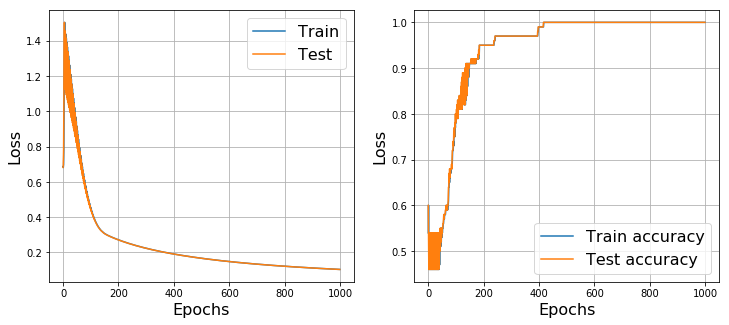

In [38]:
plot_res(train_loss, train_acc, dev_loss, dev_acc)

# K

In [39]:
alpha = 1e-5
nn = NeuralNetwork([
    Linear(300, 100, alpha),
    ReLU(),
    Linear(100, 2, alpha),
])

In [40]:
%%time
train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts, y_train, 
                                                  vecs_dev_texts, y_dev, 
                                                  1e-2, 150, 128, alpha)

Epoch 149... (Train/Test) NLL: 0.369/0.374	Accuracy: 0.841/0.835Wall time: 1min 58s


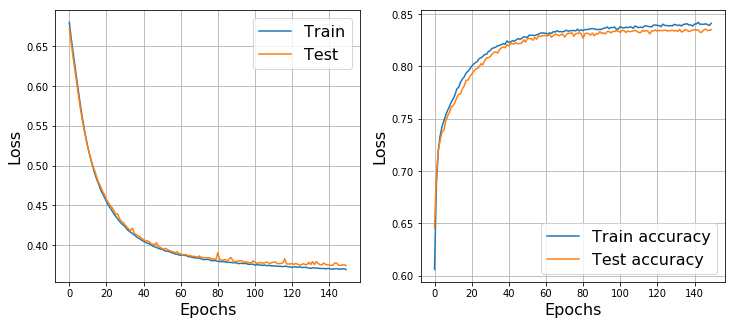

0.835578762755102 146


In [41]:
plot_res(train_loss, train_acc, dev_loss, dev_acc)
print(max(dev_acc), np.argmax(dev_acc))

# L

См. исследовательскую часть

# M

In [42]:
alpha = 1e-3
nn = NeuralNetwork([
    Linear(300, 100, alpha),
    ReLU(),
    Linear(100, 2, alpha),
])

In [43]:
%%time
train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts, y_train, 
                                                  vecs_dev_texts, y_dev, 
                                                  0.01, 150, 128, alpha)

Epoch 149... (Train/Test) NLL: 0.521/0.527	Accuracy: 0.839/0.833Wall time: 2min 26s


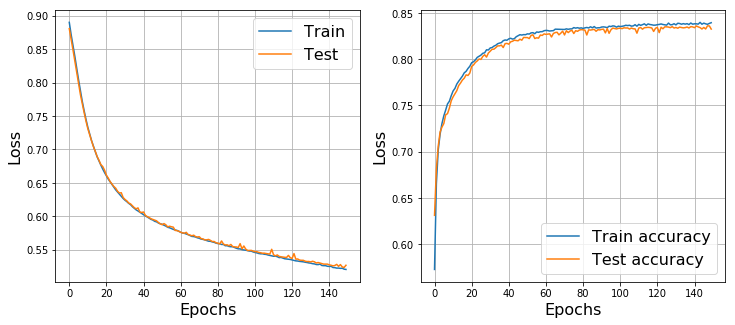

0.8360411352040815 147


In [44]:
plot_res(train_loss, train_acc, dev_loss, dev_acc)
print(max(dev_acc), np.argmax(dev_acc))